In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import  seaborn as sns

from scipy.stats import entropy
from sklearn.preprocessing import  MinMaxScaler


In [2]:
# 导入用户所有的网格信息
path = 'D:/317研究组/4 居住自选择/data/sample1000_all_grid.csv'
all_grid = pd.read_csv(path)
all_grid.head()

,who,date,fnid,chess_x,chess_y,home_fre,home_time,od_num
0,62,20190701,51457,49,144,6,359057,31
1,62,20190701,55027,49,154,1,7472,1
2,62,20190801,51490,82,144,0,15467,2
3,62,20190801,52514,35,147,0,13913,2
4,62,20190801,52179,57,146,9,585078,50


In [3]:
# 数据量
print(all_grid.shape[0])
# 计算homegrid中home_fre=0的数据量
print(all_grid[all_grid['home_fre']==0].shape[0])
# 删除home_fre=0的数据
all_grid = all_grid[all_grid['home_fre']!=0]
print(all_grid[all_grid['home_fre']==0].shape[0])

128118
34412
0


## 识别每个月的家

In [4]:
## 首先识别每个月内最大驻留频次的网格
homegrid = all_grid.copy()
homegrid['max_fre'] = homegrid.groupby(['who','date'])['home_fre'].transform('max')
homegrid['max_time'] = homegrid.groupby(['who','date'])['home_time'].transform('max')
homegrid_dominant = homegrid[homegrid['home_fre']==homegrid['max_fre']]
#homegrid_dominant.groupby(['who','date'])['fnid'].count()
#homegrid_dominant = homegrid_dominant[homegrid_dominant['home_time']==homegrid_dominant['max_time']].reset_index(drop=True)

In [18]:
len(homegrid_dominant)

16555

In [5]:
# 如果一个用户在一个月内存在多个最大驻留频次的网格，则选择驻留时间更长的
grid_month_count = homegrid_dominant.groupby(['who','date']).agg(fnid_count=('fnid','count')).reset_index()
# 选出fnid_count>1的who, date
grid_month_count = grid_month_count[grid_month_count['fnid_count']>1]
# 选出homegrid_dominant中fnid_count>1的数据，并仅保留home_time=max_time的数据
homegrid_dominant_replace = pd.merge(homegrid_dominant, grid_month_count,how='inner',on=['who','date'])
homegrid_dominant_replace = homegrid_dominant_replace.drop(columns='fnid_count')
# 删除homegrid_dominant中homegrid_dominant_replace的数据
homegrid_dominant = pd.concat([homegrid_dominant,homegrid_dominant_replace])
homegrid_dominant.drop_duplicates(subset=['who','date','fnid'],keep=False,inplace=True)

# 选出对应最大时长的数据
homegrid_dominant_replace = homegrid_dominant_replace[homegrid_dominant_replace['home_time'] == homegrid_dominant_replace['max_time']]
# 合并到homegrid_dominant中
homegrid_dominant = pd.concat([homegrid_dominant,homegrid_dominant_replace])

In [350]:
len(homegrid_dominant_replace)

258

In [351]:
len(homegrid_dominant)

16131

In [20]:
# 验证一下是否每个人每个月都仅有一个dominant grid
print(max(homegrid_dominant.groupby(['who','date'])['fnid'].count()))
print(min(homegrid_dominant.groupby(['who','date'])['fnid'].count()))

1
1


## 识别家网格的组团

In [6]:
# 定义一个函数，用于识别每个月的家网格的组团
# 输入：每个用户的家网格数据
# 如果每个月的网格在同一个十六宫格内（即chess_x的差值和chess_y的差值都小于等于3），则认为是同一个组团
# 输出：每个月的家网格组团
def find_group(df):
    #print(df)
    # index重置
    df = df.sort_values(by=['date','fnid']).reset_index(drop=True)
    # 得到总网格数
    n_grids = len(df)
    # 初始化组团标签
    labs = ["UNCLASSIFIED"] * n_grids
    # 初始化组团id
    group_id = 0

    # 遍历每个网格
    for i in range(n_grids):
        # 如果当前网格已经被分类，则跳过
        if labs[i] != "UNCLASSIFIED":
            continue
        # 得到与当前网格在同一个十六宫格内的网格
        chess_x = df.iloc[i]['chess_x']
        chess_y = df.iloc[i]['chess_y']
        df_neighbor = df[(abs(df['chess_x']-chess_x) <= 3) & (abs(df['chess_y']-chess_y) <= 3)]
        # 获得index list
        index_list = df_neighbor.index.tolist()
        # 如果当前网格是孤立的，则将其标记为noise
        if len(df_neighbor) == 1:
            labs[i] = "NOISE"
            continue
        #遍历组团内的其他网格
        for index,grid in df_neighbor.iterrows():
            #计算该点的邻近点，创建一个新的df_neighbor，新的df_neighbor的index不在index_list中
            new_df_neighbor = df[(abs(df['chess_x']-grid['chess_x']) <= 3) & (abs(df['chess_y']-grid['chess_y']) <= 3) & (~df.index.isin(index_list))]
            if len(new_df_neighbor) != 0:
                df_neighbor = pd.concat([df_neighbor,new_df_neighbor],axis=0)

        # 为所有df_neighbor中的网格标记组团id
        for index, grid in df_neighbor.iterrows():
            labs[index] = group_id
        group_id += 1
    return labs

In [7]:
# 对每个用户的家网格进行组团，返回的组团标签作为新的一列
who_home = homegrid_dominant.groupby('who', group_keys=False)
cluster = who_home.apply(lambda  x: find_group(x)).reset_index()
cluster = cluster.rename(columns={0:'group_id'})

In [8]:
# 排序以匹配列
homegrid_dominant = homegrid_dominant.sort_values(by=['who','date']).reset_index(drop=True)
cluster = cluster.sort_values(by=['who']).reset_index(drop=True)

# 遍历cluster中的每一行，将group_id整合为一个list
GROUP_ID = []
for _,data in cluster.iterrows():
    GROUP_ID.extend(data['group_id'])
# 使用GROUP_ID新建homegrid_dominant中的group_id列
homegrid_dominant['group_id'] = GROUP_ID

In [11]:
len(GROUP_ID)

16131

In [12]:
len(homegrid_dominant)

16131

In [109]:
homegrid_dominant.tail(20)

,who,date,fnid,chess_x,chess_y,wkt,start_std,home_time,home_fre,timeline,max_fre,max_time,group_id
16131,39042,20190201,5772,60,16,"MULTIPOLYGON (((113.89557983 22.48285532, 113....",7.246588,501357,16,4.0,16,501357,0
16132,39042,20190301,5772,60,16,"MULTIPOLYGON (((113.89557983 22.48285532, 113....",6.334353,346058,10,5.0,10,346058,0
16133,39042,20190401,5772,60,16,"MULTIPOLYGON (((113.89557983 22.48285532, 113....",4.357951,252313,16,6.0,16,252313,0
16134,39042,20190501,5772,60,16,"MULTIPOLYGON (((113.89557983 22.48285532, 113....",7.510754,708795,22,7.0,22,708795,0
16135,39042,20190601,5415,60,15,"MULTIPOLYGON (((113.89557983 22.48063936, 113....",7.392440,685699,27,8.0,27,685699,0
16136,39042,20190701,6492,66,18,"MULTIPOLYGON (((113.91022185 22.48728723, 113....",6.303941,891865,18,9.0,18,891865,1
16137,39042,20190801,6492,66,18,"MULTIPOLYGON (((113.91022185 22.48728723, 113....",5.142896,685114,15,10.0,15,685114,1
16138,39042,20190901,6492,66,18,"MULTIPOLYGON (((113.91022185 22.48728723, 113....",5.297711,924464,14,11.0,14,924464,1
16139,39042,20191001,6492,66,18,"MULTIPOLYGON (((113.91022185 22.48728723, 113....",8.812468,1114743,30,12.0,30,1114743,1
16140,39042,20191101,6492,66,18,"MULTIPOLYGON (((113.91022185 22.48728723, 113....",6.574285,546730,13,13.0,13,546730,1


In [66]:
# 计算group_id没有NOISE的用户
homegrid_dominant[homegrid_dominant['group_id']=='NOISE']['who'].nunique()

629

In [57]:
test = homegrid_dominant[homegrid_dominant['who']==20504][['who','date','chess_x','chess_y','home_fre','group_id']].reset_index(drop=True)
test

,who,date,chess_x,chess_y,home_fre,group_id
0,20504,20190101,24,123,7,0
1,20504,20190201,21,122,21,0
2,20504,20190301,17,122,14,NOISE
3,20504,20190401,14,117,12,NOISE
4,20504,20190501,28,95,12,1
5,20504,20190601,28,97,13,1
6,20504,20190701,52,146,24,NOISE
7,20504,20190801,67,151,27,NOISE
8,20504,20190901,86,118,34,NOISE
9,20504,20191001,65,63,22,NOISE


## 对NOISE进一步判断（TOPSIS综合评价）
<font size=6>在上一步中被定义为NOISE的月份不一定真的是NOISE，而是由于home_fre最大的条件过于苛刻，因此对于NOISE的月份，结合驻留频次、驻留时长、出入度进行综合评价</font>
<font size=6>核心思想是解决一个问题：判断NOISE是真的NOISE还是连续迁居</font>

OptionError: "No such keys(s): 'mode.use_inf_as_null'"

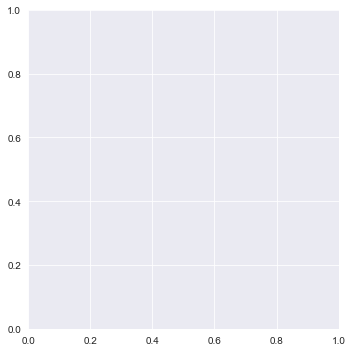

In [9]:
# 看看每个用户的组团数量的分布情况
group_distri = homegrid_dominant[homegrid_dominant['group_id']!='NOISE'].groupby('who')['group_id'].nunique().sort_values(ascending=False)
sns.displot(group_distri)

In [ ]:
# 定义熵权法评价函数
# input : data-NOISE对应月份的所有网格数据
def entropy_weight_evaluation(data):
    # 将data中待评价的三个指标home_fre, home_time, od_num转化为array
    factor_array = np.array(data[['home_fre', 'od_num']])
    # 使用MinMaxScaler函数对factor_array的每列数据规范化
    factor_array = MinMaxScaler().fit_transform(factor_array)

    n, m = factor_array.shape # 对象个数和特征个数
    # 计算每个指标的信息熵
    entropy_list = []
    for i in range(m):
        entropy_list.append(1/np.log(n)*entropy(factor_array[:,i]))

    # 计算每个指标的信息熵权重
    weight_list = []
    for entropy_i in entropy_list:
        weight_list.append(1- entropy_i)
    weight_list = weight_list/sum(weight_list)

    # 计算每个网格的综合得分
    scores = []
    for i in range(n):
        score_i = 0
        for j in range(m):
            score_i += weight_list[j] * factor_array[i,j]
        scores.append(score_i)

    return scores

In [13]:
# 定义TOPSIS评价函数
# input : data-NOISE对应月份的所有网格数据
def topsis_evaluation(data):
    SCORES = []
    #应该对每个月的情况进行评价
    for date in data['date'].unique():
        evaluate_data = data[data['date']==date]
        # 如果evaluate_data中只有一条数据，那么直接赋一个score=1
        if len(evaluate_data) == 1:
            SCORES.append(1)
            continue
        # 将evaluate_data中待评价的三个指标home_fre, home_time, od_num转化为array
        factor_array = np.array(evaluate_data[['home_fre', 'home_time', 'od_num','is_group']])
        # 使用MinMaxScaler函数对factor_array的每列数据规范化
        factor_array = MinMaxScaler().fit_transform(factor_array)

        n, m = factor_array.shape # 对象个数和特征个数
        # 获得每个指标的正负理想解
        ideal_best = []; ideal_worst = []
        for i in range(m):
            ideal_best.append(max(factor_array[:,i]))
            ideal_worst.append(min(factor_array[:,i]))

        # 计算每个样本到正负理想解的距离
        scores = []
        for i in range(n):
            distance_best = np.sqrt(sum((factor_array[i,:]-ideal_best)**2))
            distance_worst = np.sqrt(sum((factor_array[i,:]-ideal_worst)**2))
            score_i = distance_worst / (distance_best + distance_worst)
            scores.append(score_i)

        SCORES.extend(scores)

    return SCORES

In [10]:
#找出仍是NOISE的月份的all_grid数据
noise_data = homegrid_dominant[homegrid_dominant['group_id'] == 'NOISE'][['who', 'date']].drop_duplicates()
noise_all_grid = pd.merge(all_grid, noise_data, on=['who', 'date'], how='inner')

In [11]:
# 对每个用户的noise网格用同样的方法进行组团，返回的组团标签作为新的一列
noise_all_grid = noise_all_grid.sort_values(by=['who','date','fnid']).reset_index(drop=True)
who_noise = noise_all_grid['who'].unique()
for who in who_noise:
        data = noise_all_grid[noise_all_grid['who'] == who]
        group_id = find_group(data)
        noise_all_grid.loc[noise_all_grid['who'] == who, 'group_id'] = group_id

# 对noise_all_grid新增一例，如果group_id=NOISE则等于0，否则等于1
noise_all_grid['is_group'] = noise_all_grid['group_id'].apply(lambda x: 0 if x == 'NOISE' else 1)

In [59]:
noise_all_grid[noise_all_grid['who']==20504][['who','date','fnid','chess_x','chess_y','home_fre','od_num','is_group']]

,who,date,fnid,chess_x,chess_y,home_fre,od_num,is_group
3345,20504,20190301,18003,153,50,1,2,1
3346,20504,20190301,21859,82,61,1,1,1
3347,20504,20190301,24720,87,69,1,1,0
3348,20504,20190301,43564,10,122,1,3,1
3349,20504,20190301,43571,17,122,14,54,1
...,...,...,...,...,...,...,...,...
3430,20504,20200501,33030,186,92,6,0,1
3431,20504,20200501,35461,118,99,6,5,1
3432,20504,20200501,37685,200,105,13,14,1
3433,20504,20200501,45719,23,128,1,0,1


In [14]:
# 对每个用户的noise_all_grid进行topsis综合评价，获得每个grid的综合得分
for who in who_noise:
        data = noise_all_grid[noise_all_grid['who'] == who]
        scores = topsis_evaluation(data)
        noise_all_grid.loc[noise_all_grid['who'] == who, 'score'] = scores

C:\Users\huangnx\AppData\Local\Temp\ipykernel_30904\3572032651.py:29: RuntimeWarning: invalid value encountered in double_scalars
  score_i = distance_worst / (distance_best + distance_worst)
C:\Users\huangnx\AppData\Local\Temp\ipykernel_30904\3572032651.py:29: RuntimeWarning: invalid value encountered in double_scalars
  score_i = distance_worst / (distance_best + distance_worst)


In [15]:
# 找出每月最大的综合得分
noise_all_grid['max_score'] = noise_all_grid.groupby(['who','date'])['score'].transform('max')
noise_dominant = noise_all_grid[noise_all_grid['score']==noise_all_grid['max_score']]

# 删除noise_dominant中的group_id=NOISE的行
noise_dominant = noise_dominant[noise_dominant['group_id'] != 'NOISE']

In [55]:
noise_dominant[noise_dominant['who']==446][['who','date','fnid','home_fre','od_num','is_group']]

,who,date,fnid,home_fre,od_num,is_group
51,446,20190801,31178,6,8,1
55,446,20190901,31179,8,36,1
60,446,20191001,32961,8,19,1
65,446,20191101,32961,9,39,1
69,446,20200301,15501,1,2,1
70,446,20200401,42525,9,54,1
73,446,20200501,42525,6,8,1


In [16]:
# 要将原来homegrid_dominant中的NOISE替换为新的group_id，不是把group_id直接替换这么简单，因为新的group_id会和原来的group_id冲突
for who in noise_dominant['who'].unique():
    max_group_id = homegrid_dominant[(homegrid_dominant['who'] == who) & (homegrid_dominant['group_id']!='NOISE')]['group_id'].max()
    noise_dominant.loc[noise_dominant['who'] == who, 'group_id'] = noise_dominant.loc[noise_dominant[
                                                                                          'who'] == who, 'group_id'] + max_group_id + 1

# 替换
new_homegrid_dominant = homegrid_dominant.set_index(['who', 'date'])
new_noise_dominant  = noise_dominant.set_index(['who', 'date'])
new_homegrid_dominant.update(new_noise_dominant)

# 更新homegrid_dominant
homegrid_dominant = new_homegrid_dominant.sort_values(by=['who', 'date']).reset_index()

ValueError: cannot handle a non-unique multi-index!

In [41]:
all_grid[all_grid['who']==20504]

,who,date,fnid,chess_x,chess_y,home_fre,home_time,od_num
69045,20504,20190101,43939,28,123,3,171583,11
69046,20504,20190101,43935,24,123,7,428580,37
69048,20504,20190101,40371,30,113,1,4311,0
69049,20504,20190201,40371,30,113,1,5520,0
69050,20504,20190201,46432,22,130,1,6148,0
...,...,...,...,...,...,...,...,...
69267,20504,20200501,35461,118,99,6,115015,5
69268,20504,20200501,19342,64,54,1,30836,0
69269,20504,20200501,45722,26,128,2,25696,0
69270,20504,20200501,33030,186,92,6,47822,0


In [40]:
homegrid_dominant[homegrid_dominant['who']==20504][['who','date','fnid','group_id']]

,who,date,fnid,group_id
8602,20504,20190101,43935.0,0
8603,20504,20190201,43575.0,0
8604,20504,20190301,43571.0,7
8605,20504,20190401,41783.0,9
8606,20504,20190501,33943.0,1
8607,20504,20190601,34657.0,1
8608,20504,20190701,52174.0,10
8609,20504,20190801,53974.0,NOISE
8610,20504,20190901,42212.0,13
8611,20504,20191001,22556.0,14


In [73]:
# 计算group_id没有NOISE的用户
homegrid_dominant[homegrid_dominant['group_id']=='NOISE']['who'].nunique()

518

## 解决家网格的月度差异
<font size=6 >case 1：如果用户的家网格的变化是有序的，如{0,0,0,1,1,1,2,2,2}，那么我们认为该用户的居住网格是不需要调整的（即便有NOISE），这是一种显著的迁居行为 </font>
<font size=6 >case 2：如果用户的家网格是混乱的，如{0,1,0,0,1,1,0,0}，那么会有两种原因导致这种情况：（1）用户可能有多个家，即0和1组团都是他的家 → 可以看看这两个组团是否会同在一个月中出现 ；（2）存在组团是干扰项 - 这种情况出现在：这个月的记录较少，因此虽然这个网格在该月驻留频次最多的，但是绝对数量上并不多（比如只有一两次）→ 要确立一个判断标准</font>

### step 1：删除平均月驻留频次小于4的group_id

<font size=6>在排序无序的居住地网格中，有的组团实际上是由于这个月数据量太少导致的，实际上并不是真正的家，如下图</font>
![1](img/unsorted_situation.png)
<font size=6>【1】首先定义多少的频次算少（一周一次，即组团的月均活动频次为4），对平均频次小于标准的组团认为是一个次锚点，把group_id改成"NOISE"（该操作针对所有用户，不仅是排序混乱的用户）</font>
<font size=6>【2】对频次满足标准的，可以认为有两（多）个家</font>

In [17]:
# 筛选出homegrid_dominant中月均驻留频次小于4的组团
# 根据who和group_id分组，计算每个组团的平均驻留频次
homegrid_dominant['avg_fre'] = homegrid_dominant.groupby(['who','group_id'])['home_fre'].transform('mean')
# 将homegrid_unsorted中avg_fre列<4的数据的group_id替换为'NOISE'
homegrid_dominant.loc[homegrid_dominant['avg_fre']<4,'group_id'] = 'NOISE'

In [18]:
def reorder_list(lst):
  # 创建一个空的字典，用来存储每个类别对应的新数字
  category_dict = {}
  # 初始化一个变量，用来表示当前的新数字
  current_num = 0
  # 创建一个空的list，用来存储重新排序后的结果
  result = []
  # 遍历原始的list，对每个数字进行替换，并添加到结果list中
  for num in lst:
    # 如果数字在字典中已经存在，那么就用字典中对应的新数字来替换
    if num in category_dict:
      result.append(category_dict[num])
    # 否则，就用当前的新数字来替换，并把它添加到字典中
    else:
      result.append(current_num)
      category_dict[num] = current_num
      # 把当前的新数字加一，继续循环
      current_num += 1
  # 返回结果list
  return result

In [19]:
# group_id重置
for who in homegrid_dominant['who'].unique():
    group_id = homegrid_dominant[(homegrid_dominant['who'] == who) & (homegrid_dominant['group_id']!='NOISE')]['group_id']
    group_id = reorder_list(group_id)
    homegrid_dominant.loc[(homegrid_dominant['who'] == who)&(homegrid_dominant['group_id']!='NOISE'),'group_id'] = group_id

In [20]:
# 定义一个判断数组状态的函数
# 使用迭代的方法
def listSortedOrNot (group_list):
  n = len(group_list)
  if n <= 1:
    return True
  for i in range (1,n):
    if group_list [i - 1] > group_list [i]:
      return False
  return True

In [21]:
 # 找出需要进一步分析居住网格情况的用户，也就是网格组团的变化是混乱的用户
# 先剔除NOISE的部分（不纳入分析）
homegrid_without_noise = homegrid_dominant[homegrid_dominant['group_id']!='NOISE']
who_home2 = homegrid_without_noise.groupby('who', group_keys=False)
grid_sorted = who_home2.apply(lambda  x: listSortedOrNot(x['group_id'].tolist())).reset_index()
grid_sorted = grid_sorted.rename(columns={0:'is_sorted'})

# 利用grid_sorted区分用户
homegrid_sorted = homegrid_dominant[homegrid_dominant['who'].isin(grid_sorted[grid_sorted['is_sorted']==True]['who'].unique())]
homegrid_unsorted = homegrid_dominant[homegrid_dominant['who'].isin(grid_sorted[grid_sorted['is_sorted']==False]['who'].unique())]

In [442]:
# 有多少个who的group_id被替换为"SECONDARY"
homegrid_unsorted[homegrid_unsorted['group_id']==-1]['who'].unique().shape[0]

70

In [22]:
# 用homegrid_unsorted更新homegrid_dominant
replace_scondary = homegrid_unsorted[homegrid_unsorted['group_id']==-1].set_index(['who','date'])
new_homegrid_dominant = homegrid_dominant.set_index(['who','date'])
new_homegrid_dominant.update(replace_scondary)

## 更新homegrid_dominant
homegrid_dominant = new_homegrid_dominant.reset_index()

###  处理noise值
<font size=6>1. 如果NOISE上下的网格一致（且不为NOISE），则将NOISE改写为其临近的label</font>
<font size=6>2. 如果NOISE上下的网格不一致（且存在其一不为NOISE），判断NOISE中有没有在其十六宫格的网格，有的话则将NOISE改写为其临近的label</font>

In [23]:
#查找candidate_grid中的网格有没有与data中该对应组团一致的网格
def search_in_candidate_grid(data, candidate_grid, group):
    chessx_max = data[data['group_id']==group]['chess_x'].max()
    chessx_min = data[data['group_id']==group]['chess_x'].min()
    chessy_max = data[data['group_id']==group]['chess_y'].max()
    chessy_min = data[data['group_id']==group]['chess_y'].min()
    for _,grid in candidate_grid.iterrows():
        if (grid['chess_x']<= chessx_max+3) and (grid['chess_x'] >= chessx_min-3) and (grid['chess_y']<= chessy_max+3) and (grid['chess_y'] >= chessy_min-3):
            return  grid, group
    return -1, -1

In [24]:
def noise_solve(home_grid, all_grid):
    replace_grid = pd.DataFrame(columns=home_grid.columns)
    # index重置
    home_grid = home_grid.sort_values(by='date').reset_index(drop=True)
    all_grid = all_grid.sort_values(by='date').reset_index(drop=True)
    # 获取group_id='NOISE'的数据的index
    noise_index = home_grid[home_grid['group_id']=='NOISE'].index.tolist()
    # 遍历noise_index
    for i in noise_index:
        # 获取这个who这个月的所有网格作为candidate_grid
        candidate_grid = all_grid[all_grid['date']==home_grid.loc[i,'date']].reset_index(drop=True)
        # 如果index是第一个或者最后一个，则将above和below赋同样的值
        if i == 0:
            group_above = home_grid.loc[i+1,'group_id']; group_below = home_grid.loc[i+1,'group_id']
        elif i == len(home_grid)-1:
            group_above = home_grid.loc[i-1,'group_id']; group_below = home_grid.loc[i-1,'group_id']
        else:
            # 找到NOISE上下的网格
            group_above = home_grid.loc[i-1,'group_id']; group_below = home_grid.loc[i+1,'group_id']

        # 开始判断和更新
        # step1：如果NOISE上下月份网格一致，并且不等于‘NOISE’，则将NOISE改写为其临近的group_id（必修改）
        if (group_above == group_below) and (group_above != 'NOISE'):
            # 将NOISE替换为其临近的group_id
            home_grid.loc[i,'group_id'] = group_above
            #同时替换网格的其他信息
            #先赋个初值，如果以下条件找不到，就用初值
            home_grid.loc[i,['fnid','chess_x','chess_y','home_fre','home_time','od_num']] = [None, None, None, None, None, None]
            #查找candidate_grid中的网格有没有与data中该对应组团一致的网格
            grid, group= search_in_candidate_grid(home_grid, candidate_grid, group_above)
            # group=-1证明没有找到，使用初值
            if group != -1:
                home_grid.loc[i,['fnid','chess_x','chess_y','home_fre','home_time','od_num']] = grid[['fnid','chess_x','chess_y','home_fre','home_time','od_num']]
            # 将data添加到replace_grid中
            replace_grid = pd.concat([replace_grid, home_grid.loc[i:i]], axis=0)
        # step2：NOISE上下月份网格不一致，但是存在不是NOISE的情况（不一定修改）
        elif (group_above != group_below) and (group_above != 'NOISE' or group_below != 'NOISE'):
            # 分别查找candidate_grid中的网格
            group1= -1; group2 = -1
            if group_above != 'NOISE':
                grid1, group1 = search_in_candidate_grid(home_grid, candidate_grid, group_above)
            if group_below != 'NOISE':
                grid2, group2 = search_in_candidate_grid(home_grid, candidate_grid, group_below)
            # 如果grid1和grid2都不为None，则将NOISE替换为grid1和grid2中home_fre较大的那个，否则将NOISE替换为grid1或者grid2
            if group1 != -1 and group2 != -1:
                grid = grid1 if grid1['home_fre'] > grid2['home_fre'] else grid2
                group = group1 if grid1['home_fre'] > grid2['home_fre'] else group2
                home_grid.loc[i,'group_id'] = group
                home_grid.loc[i,['fnid','chess_x','chess_y','home_fre','home_time','od_num']] = grid[['fnid','chess_x','chess_y','home_fre','home_time','od_num']]
                replace_grid = pd.concat([replace_grid, home_grid.loc[i:i]], axis=0)
            elif group1 != -1 or group2 != -1:
                grid = grid1 if group1 != -1 else grid2
                group = group1 if group1 != -1 else group2
                home_grid.loc[i,'group_id'] = group
                home_grid.loc[i,['fnid','chess_x','chess_y','home_fre','home_time','od_num']] = grid[['fnid','chess_x','chess_y','home_fre','home_time','od_num']]
                replace_grid = pd.concat([replace_grid, home_grid.loc[i:i]], axis=0)

    return  replace_grid

In [25]:
#（1）如果NOISE上下的网格一致，则将NOISE改写为其临近的label
#（2）如果NOISE上下的网格不一致（且存在其一不为NOISE），判断NOISE中有没有在其十六宫格的网格，有的话则将NOISE改写为其临近的labe
# 找到homegrid_dominant中的group_id为NOISE的数据的who
who_noise = homegrid_dominant[homegrid_dominant['group_id']=="NOISE"]['who'].unique()
replace_grid = pd.DataFrame(columns=homegrid_dominant.columns)

# 循环判断每个who中的情况
for who in who_noise:
    who_home = homegrid_dominant[homegrid_dominant['who']==who].reset_index(drop=True)
    who_data = all_grid[all_grid['who']==who].reset_index(drop=True)
    replace = noise_solve(who_home, who_data)
    # 如果replace不为空，则将replace添加到replace_grid中
    if len(replace) != 0:
        replace_grid = pd.concat([replace_grid, replace], axis=0)

KeyError: 1

In [307]:
homegrid_dominant.head()

,who,date,fnid,home_fre,home_time,chess_x,chess_y,max_fre,max_time,group_id
0,62,20190701,51457.0,6.0,359057.0,49.0,144.0,6.0,359057.0,NOISE
1,62,20190801,52179.0,9.0,585078.0,57.0,146.0,9.0,585078.0,0
2,62,20190901,52178.0,10.0,679021.0,56.0,146.0,10.0,679021.0,0
3,62,20191001,52871.0,20.0,562133.0,35.0,148.0,20.0,747358.0,1
4,62,20191101,52871.0,16.0,842812.0,35.0,148.0,16.0,842812.0,1


In [ ]:
# 用replace_grid更新homegrid_dominant
new_homegrid_dominant = homegrid_dominant.set_index(['who','date'])
replace_grid.set_index(['who','date'],inplace=True)
new_homegrid_dominant.update(replace_grid)
print('替换前NOISE的个数为', len(homegrid_dominant[homegrid_dominant['group_id']=='NOISE']))
print('替换后NOISE的个数为', len(new_homegrid_dominant[new_homegrid_dominant['group_id']=='NOISE']))

# 更新homegrid_dominant
homegrid_dominant = new_homegrid_dominant.sort_values(by=['who','date']).reset_index()

In [79]:
# 计算group_id没有NOISE的用户
homegrid_dominant[homegrid_dominant['group_id']=='NOISE']['who'].nunique()

114

OptionError: "No such keys(s): 'mode.use_inf_as_null'"

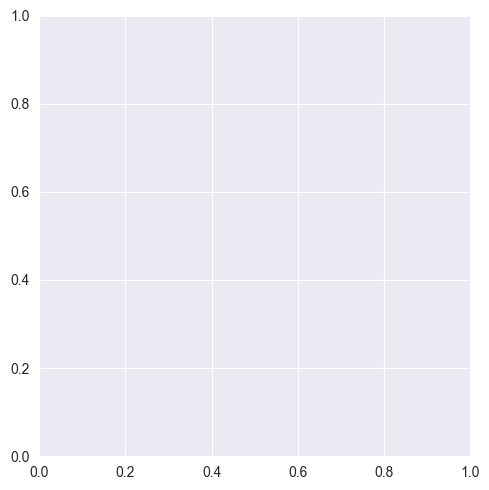

In [26]:
# 看看处理后每个用户的组团数量的分布情况
group_distri = homegrid_dominant[homegrid_dominant['group_id']!='NOISE'].groupby('who')['group_id'].nunique().sort_values(ascending=False)
sns.displot(group_distri)

In [27]:
homegrid_dominant[homegrid_dominant['who']==20504]

,who,date,fnid,chess_x,chess_y,home_fre,home_time,od_num,max_fre,max_time,group_id,avg_fre
8602,20504,20190101,43935.0,24.0,123.0,7.0,428580.0,37.0,7,428580,0,14.0
8603,20504,20190201,43575.0,21.0,122.0,21.0,980512.0,48.0,21,980512,0,14.0
8604,20504,20190301,43571.0,17.0,122.0,14.0,838290.0,54.0,14,838290,7,14.0
8605,20504,20190401,41783.0,14.0,117.0,12.0,570828.0,36.0,12,570828,9,12.0
8606,20504,20190501,33943.0,28.0,95.0,12.0,635494.0,43.0,12,635494,1,12.5
8607,20504,20190601,34657.0,28.0,97.0,13.0,482541.0,22.0,13,482541,1,12.5
8608,20504,20190701,52174.0,52.0,146.0,24.0,540857.0,25.0,24,540857,10,24.0
8609,20504,20190801,42569.0,86.0,119.0,3.0,90535.0,8.0,27,646339,13,27.0
8610,20504,20190901,42212.0,86.0,118.0,34.0,919691.0,45.0,34,919691,13,34.0
8611,20504,20191001,22556.0,65.0,63.0,22.0,442855.0,20.0,22,442855,14,22.0


In [27]:
# 看看有groupid='NOISE'的who的所有数据
new_homegrid_dominant = homegrid_dominant.copy()
new_who_noise = new_homegrid_dominant[new_homegrid_dominant['group_id']=='NOISE']['who'].unique()
new_homegrid_dominant[new_homegrid_dominant['who'].isin(new_who_noise)][['who','date','chess_x','chess_y','home_fre','group_id']]

,who,date,chess_x,chess_y,home_fre,group_id
0,62,20190701,49,144,6,NOISE
1,62,20190801,57,146,9,0
2,62,20190901,56,146,10,0
3,62,20191001,35,148,20,1
4,62,20191101,35,148,16,1
...,...,...,...,...,...,...
16136,39027,20200501,69,89,15,2
16137,39027,20201101,68,89,10,2
16138,39027,20210501,68,88,13,2
16139,39027,20211101,70,89,1,2


In [63]:
len(new_who_noise)

114

In [38]:
new_homegrid_dominant[~(new_homegrid_dominant['who'].isin(new_who_noise))][['who','date','chess_x','chess_y','home_fre','group_id']]

,who,date,chess_x,chess_y,home_fre,group_id
0,62,20190701,49.0,144.0,6.0,0
1,62,20190801,57.0,146.0,9.0,0
2,62,20190901,56.0,146.0,10.0,0
3,62,20191001,35.0,148.0,20.0,1
4,62,20191101,35.0,148.0,16.0,1
...,...,...,...,...,...,...
16126,39042,20200501,67.0,18.0,15.0,1
16127,39042,20201101,67.0,18.0,9.0,1
16128,39042,20210501,67.0,18.0,18.0,1
16129,39042,20211101,54.0,25.0,55.0,2


==================================================================================================================================================================================

In [65]:
who2078_home = new_homegrid_dominant[new_homegrid_dominant['who']==3743]
who2078_home.to_csv('who3743_home.csv',index=False)

In [66]:
who2078_home

,who,date,fnid,chess_x,chess_y,home_fre,home_time,od_num,max_fre,max_time,group_id,avg_fre
1466,3743,20191001,25047,57,70,20,502109,25,20,706755,0,18.0
1467,3743,20191101,25044,54,70,22,396417,22,22,747666,0,18.0
1468,3743,20191201,25402,55,71,12,270594,15,12,723044,0,18.0
1469,3743,20200101,23969,50,67,8,539611,36,8,539611,1,12.0
1470,3743,20200201,23969,50,67,15,904537,57,15,904537,1,12.0
1471,3743,20200301,23969,50,67,11,854552,62,11,854552,1,12.0
1472,3743,20200401,23969,50,67,14,874288,60,14,874288,1,12.0
1473,3743,20200501,23969,50,67,12,926748,62,12,926748,1,12.0
